In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

## 2a)

In [2]:
def elemental_stiffness_matrix(consts, h):
    alpha, b, c = consts
    return np.array([[alpha/h + b/2 + h*c/3, -alpha/h + b/2 + h*c/6],
                    [-alpha/h - b/2 + h*c/6, alpha/h - b/2 + h*c/3]])

def elemental_load(func, x1, x2, consts):
    h = x2 - x1
    f = np.zeros(2)
    f[0] = integrate.quad(lambda x: func(x, consts) * (x2 - x) / h, x1, x2)[0]
    f[1] = integrate.quad(lambda x: func(x, consts) * (x - x1) / h, x1, x2)[0]
    return f

In [3]:
def solve_system(Xk, func, consts):
    Mi = len(Xk)
    H = Xk[1:]-Xk[:-1]               # Element sizes
    Mk = Mi-1                        # Number of elements

    A = np.zeros((Mi,Mi))
    f = np.zeros((Mi))

    for k in range(0,Mk):
        Ak = elemental_stiffness_matrix(consts, H[k])
        fk = elemental_load(func, Xk[k], Xk[k+1], consts)
        A[k:k+2, k:k+2] += Ak
        f[k:k+2] += fk
    
    # Impose boundary condition
    # Dirichlet boundary conditions
    A[0,:] = 0;
    A[0,0] = 1
    f[0] = 0
    A[-1,:] = 0
    A[-1,-1] = 1
    f[-1] = 0

    U = np.linalg.solve(A,f)
    return U

In [4]:
def func_1(x, consts):
    alpha, b, c = consts
    return 2 * alpha + b * (1 - 2*x) + c * (x - x**2)

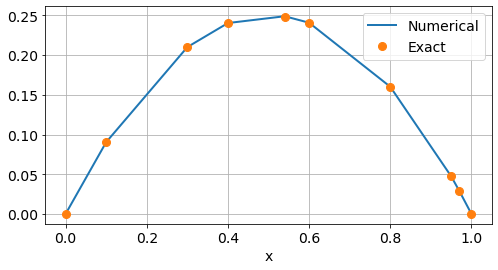

In [5]:
Xk = np.array([0, 0.1, 0.3, 0.4, 0.54, 0.6, 0.8, 0.95, 0.97, 1])

U = solve_system(Xk, func_1, [1,1,1])

plt.plot(Xk, U, Xk, Xk * (1-Xk), 'o')
plt.legend(['Numerical','Exact'])
plt.xlabel('x');


In [6]:
def func_2(x, consts):
    alpha, b, c = consts
    return 9 * np.pi**2 * alpha * np.sin(3*np.pi*x) + 3 * np.pi * b * np.cos(3*np.pi*x) + c* np.sin(3*np.pi * x)

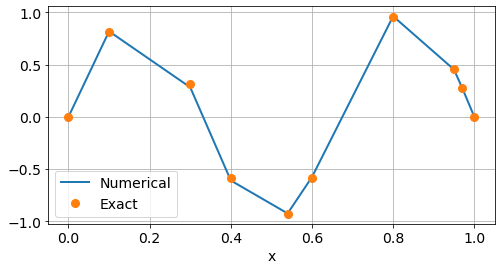

In [7]:
Xk = np.array([0, 0.1, 0.3, 0.4, 0.54, 0.6, 0.8, 0.95, 0.97, 1])

U = solve_system(Xk, func_2, [1,1,1])

plt.plot(Xk, U, Xk, np.sin(3*np.pi*Xk), 'o')
plt.legend(['Numerical','Exact'])
plt.xlabel('x');

## 2b)

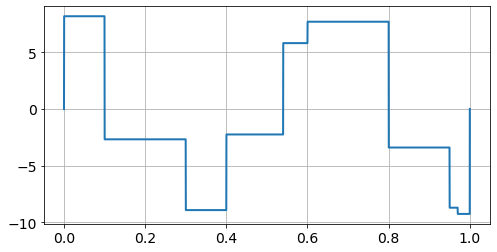

In [8]:
def uh_deriv(x, Xk, U):
    conds = []
    funs = []
    for i in range(len(Xk)- 1):
        conds.append((x > Xk[i]) * (x < Xk[i+1]))
        funs.append((U[i+1] - U[i]) / (Xk[i+1] - Xk[i]))
    return np.piecewise(x, conds, funs)

Xk = np.array([0, 0.1, 0.3, 0.4, 0.54, 0.6, 0.8, 0.95, 0.97, 1])
U = solve_system(Xk, func_2, [1,1,1])

x= np.linspace(0,1,5000)
plt.plot(x, uh_deriv(x, Xk, U))

In [9]:
def l2_norm(u):
    u_squared = lambda x: u(x)**2
    norm = np.sqrt(integrate.quad(u_squared, 0, 1))
    print("Estimated integration error: ", norm[1])
    return norm[0]

In [10]:
def convergence(num_points, func, u_exact, u_exact_deriv, consts):
    l2_errors = np.zeros(num_points)
    h1_errors = np.zeros(num_points)
    
    Mis = 2**(3 + np.arange(num_points))
    hs = 1 / Mis
    for i in range(num_points):
        Xk = np.linspace(0, 1, Mis[i])
        U = solve_system(Xk, func, consts)

        l2_errors[i] = l2_norm(lambda x: u_exact(x) - np.interp(x, Xk, U))
        h1_errors[i] = np.sqrt(l2_errors[i]**2 + l2_norm(lambda x: u_exact_deriv(x) - uh_deriv(x, Xk, U))**2)
        
    return l2_errors, h1_errors, hs

In [11]:
def u_exact_1(x):
    return x * (1 - x)

def u_exact_1_deriv(x):
    return 1 - 2 * x

def u_exact_2(x):
    return np.sin(3 * np.pi * x)

def u_exact_2_deriv(x):
    return 3 * np.pi * np.cos(3 * np.pi * x)

Estimated integration error:  0.00011748261784473952
Estimated integration error:  0.000574293536394703
Estimated integration error:  0.0001154874017489846


<ipython-input-9-68c1a6e10d86>:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  norm = np.sqrt(integrate.quad(u_squared, 0, 1))


Estimated integration error:  0.0009166336915729455
Estimated integration error:  0.00011969284998865214
Estimated integration error:  0.00034204485498223427
Estimated integration error:  3.67717366054773e-05
Estimated integration error:  0.00021666476860508725
Estimated integration error:  7.785584866559952e-06
Estimated integration error:  0.00013961971882612005


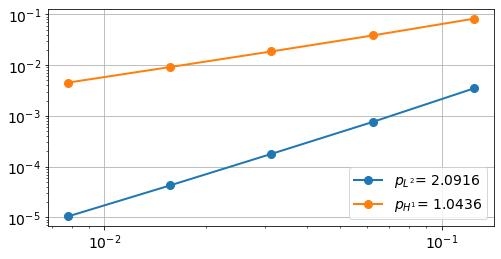

In [12]:
consts = [1, 1, 1]
l2, h1, hs = convergence(5, func_1, u_exact_1, u_exact_1_deriv, consts)

order_l2 = np.polyfit(np.log(hs),np.log(l2), 1)[0]
order_h1 = np.polyfit(np.log(hs),np.log(h1), 1)[0]

plt.loglog(hs, l2, '-o', label = r'$p_{L^{2}}$' + '= {:.4f}'.format(order_l2))
plt.loglog(hs, h1, '-o', label = r'$p_{H^{1}}$' + '= {:.4f}'.format(order_h1))
plt.legend()
plt.show()

Estimated integration error:  0.00011748261784473952
Estimated integration error:  0.000574293536394703
Estimated integration error:  0.0001154874017489846


<ipython-input-9-68c1a6e10d86>:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  norm = np.sqrt(integrate.quad(u_squared, 0, 1))


Estimated integration error:  0.0009166336915729455
Estimated integration error:  0.00011969284998865214
Estimated integration error:  0.00034204485498223427
Estimated integration error:  3.67717366054773e-05
Estimated integration error:  0.00021666476860508725
Estimated integration error:  7.785584866559952e-06
Estimated integration error:  0.00013961971882612005


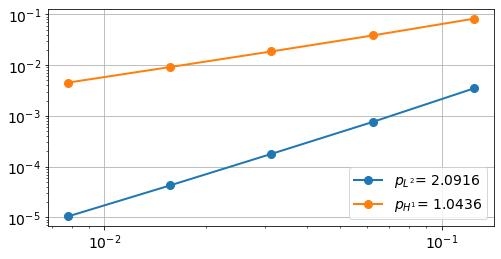

In [13]:
consts = [1, 1, 1]
l2, h1, hs = convergence(5, func_1, u_exact_1, u_exact_1_deriv, consts)

order_l2 = np.polyfit(np.log(hs),np.log(l2), 1)[0]
order_h1 = np.polyfit(np.log(hs),np.log(h1), 1)[0]

plt.loglog(hs, l2, '-o', label = r'$p_{L^{2}}$' + '= {:.4f}'.format(order_l2))
plt.loglog(hs, h1, '-o', label = r'$p_{H^{1}}$' + '= {:.4f}'.format(order_h1))
plt.legend()
plt.show()

## 2d)

In [14]:
def u_exact_3(x):
    return np.piecewise(x, [x<0.5, x>=0.5], [lambda x: 2* x, lambda x: 2*(1 - x)])

In [15]:
def func_3(x, consts):
    alpha, b, c = consts
    return np.piecewise(x, [x<0.5, x>=0.5], [lambda x: 2*b + 2*c*x, lambda x: -2*b + 2*c*(1 - x)])

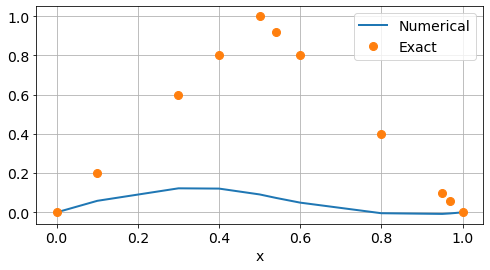

In [16]:
Xk = np.array([0, 0.1, 0.3, 0.4, 0.5, 0.54, 0.6, 0.8, 0.95, 0.97, 1])

consts = [1, 1, 1]

U = solve_system(Xk, func_3, consts)
plt.plot(Xk, U, Xk, u_exact_3(Xk), 'o')
plt.legend(['Numerical','Exact'])
plt.xlabel('x');

## 1e)

In [17]:
def func_4(x, consts):
    return x**(-1/4)

In [18]:
Xk_fine = np.linspace(0,1,10000)
consts = [1,1,1]
U_finegrid = solve_system(Xk_fine, func_4, consts)